In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import pendulum
import requests
import matplotlib.pyplot as plt

import sys
sys.path.insert(0, '..')

from src.post_forecast import process_post_forecast

import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

In [4]:
from datetime import datetime
dt = datetime(2022,1,1)
pendulum.instance(dt)

DateTime(2022, 1, 1, 0, 0, 0, tzinfo=Timezone('UTC'))

In [9]:
dt.strftime("%Y-%m-%d_%H:%M:%S")

'2022-01-01_00:00:00'

In [2]:
filename = "/home/eric/projects/data/wrfout_d02_2022-08-07_00:00:00"

In [3]:
process_post_forecast(
    filename, 
    start=pendulum.datetime(2022, 8, 6)
)

In [9]:
ds

<xarray.Dataset>
Dimensions:                (Time: 25, south_north: 92, west_east: 84,
                            bottom_top: 54, bottom_top_stag: 55,
                            soil_layers_stag: 4, west_east_stag: 85,
                            south_north_stag: 93, seed_dim_stag: 8)
Coordinates:
    XLAT                   (Time, south_north, west_east) float32 -9.529 ... ...
    XLONG                  (Time, south_north, west_east) float32 38.93 ... 6...
    XTIME                  (Time) datetime64[ns] 2022-08-06 ... 2022-08-07
    XLAT_U                 (Time, south_north, west_east_stag) float32 -9.533...
    XLONG_U                (Time, south_north, west_east_stag) float32 38.77 ...
    XLAT_V                 (Time, south_north_stag, west_east) float32 -9.686...
    XLONG_V                (Time, south_north_stag, west_east) float32 38.93 ...
Dimensions without coordinates: Time, south_north, west_east, bottom_top,
                                bottom_top_stag, soil_layers_stag,
                                west_east_stag, south_north_stag, seed_dim_stag
Data variables: (12/154)
    Times                  (Time) |S19 b'2022-08-06_00:00:00' ... b'2022-08-0...
    LU_INDEX               (Time, south_north, west_east) float32 2.0 ... 16.0
    ZNU                    (Time, bottom_top) float32 0.997 0.9903 ... 0.0003393
    ZNW                    (Time, bottom_top_stag) float32 1.0 0.9941 ... 0.0
    ZS                     (Time, soil_layers_stag) float32 0.05 0.25 ... 1.5
    DZS                    (Time, soil_layers_stag) float32 0.1 0.3 ... 0.6 1.0
    ...                     ...
    PCB                    (Time, south_north, west_east) float32 0.0 ... 0.0
    PC                     (Time, south_north, west_east) float32 0.0 ... 0.0
    LANDMASK               (Time, south_north, west_east) float32 1.0 ... 0.0
    LAKEMASK               (Time, south_north, west_east) float32 0.0 ... 0.0
    SST                    (Time, south_north, west_east) float32 289.2 ... 3...
    SST_INPUT              (Time, south_north, west_east) float32 0.0 ... 0.0
Attributes: (12/134)
    TITLE:                            OUTPUT FROM WRF V4.4 MODEL
    START_DATE:                      2022-08-06_00:00:00
    SIMULATION_START_DATE:           2022-08-06_00:00:00
    WEST-EAST_GRID_DIMENSION:        85
    SOUTH-NORTH_GRID_DIMENSION:      93
    BOTTOM-TOP_GRID_DIMENSION:       55
    ...                              ...
    ISLAKE:                          -1
    ISICE:                           24
    ISURBAN:                         1
    ISOILWATER:                      14
    HYBRID_OPT:                      2
    ETAC:                            0.2

In [51]:
ds = xr.load_dataset(filename, engine="netcdf4")

start = pendulum.datetime(2022, 8, 6)
end = start.add(hours=24)

period = pendulum.period(start, end)

ds = ds.assign_coords({"Time": list(period.range("hours", 1))})
ds["windspeed"] = np.sqrt((ds["U10"]**2 + ds["V10"]**2))
ds["wind_direction"] = (np.rad2deg(np.arctan(ds["V10"] / ds["U10"])) * 2)

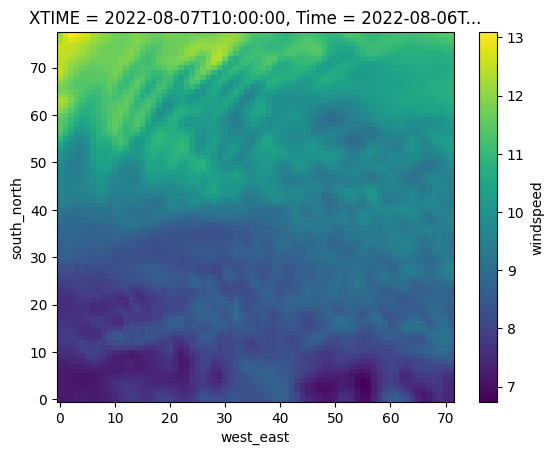

In [52]:
ds["windspeed"][10].plot()

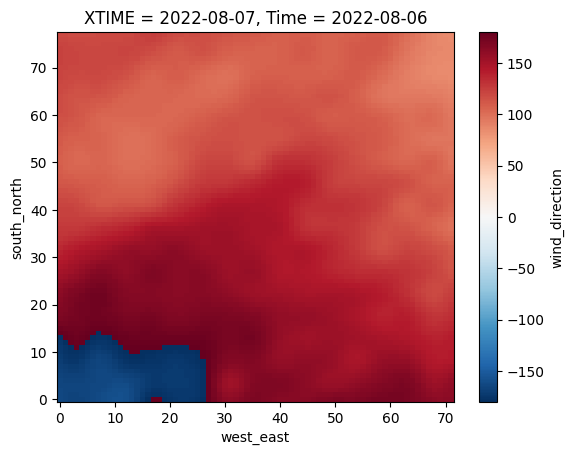

In [53]:
ds["wind_direction"][0].plot()

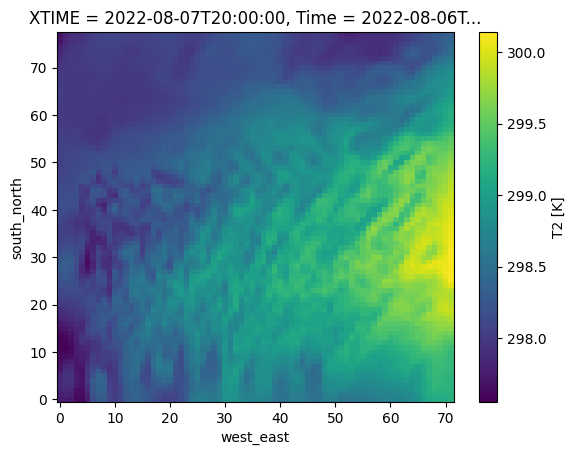

In [56]:
ds["T2"][20].plot()

/tmp/ipykernel_75315/899847229.py:7: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pcm=axs[0].pcolormesh(lons,lats,temp,cmap='viridis')


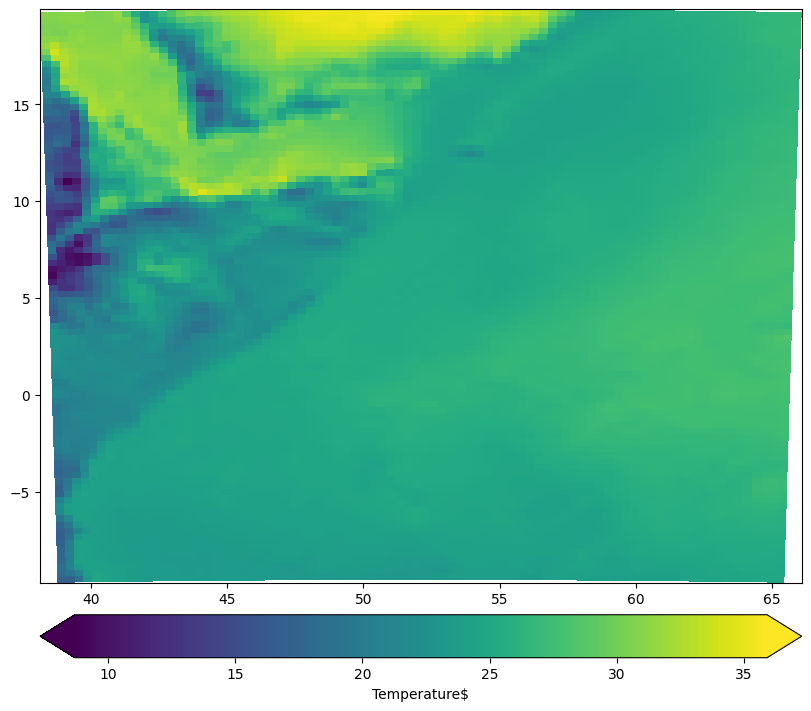

In [20]:
timestep = 0
lats = ds.coords['XLAT'][timestep]  # extract/copy the data
lons = ds.coords['XLONG'][timestep]
temp = ds.variables['T2'][timestep] - 273

fig, axs = plt.subplots(figsize=(8, 7), nrows=2,ncols=1,gridspec_kw={'height_ratios': [20,1.5]},constrained_layout=True)
pcm=axs[0].pcolormesh(lons,lats,temp,cmap='viridis')
cbar=fig.colorbar(pcm,cax=axs[1], extend='both', orientation='horizontal')
cbar.set_label('Temperature$')

/tmp/ipykernel_75315/2751612143.py:7: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pcm=axs[0].pcolormesh(lons,lats,temp,cmap='viridis')


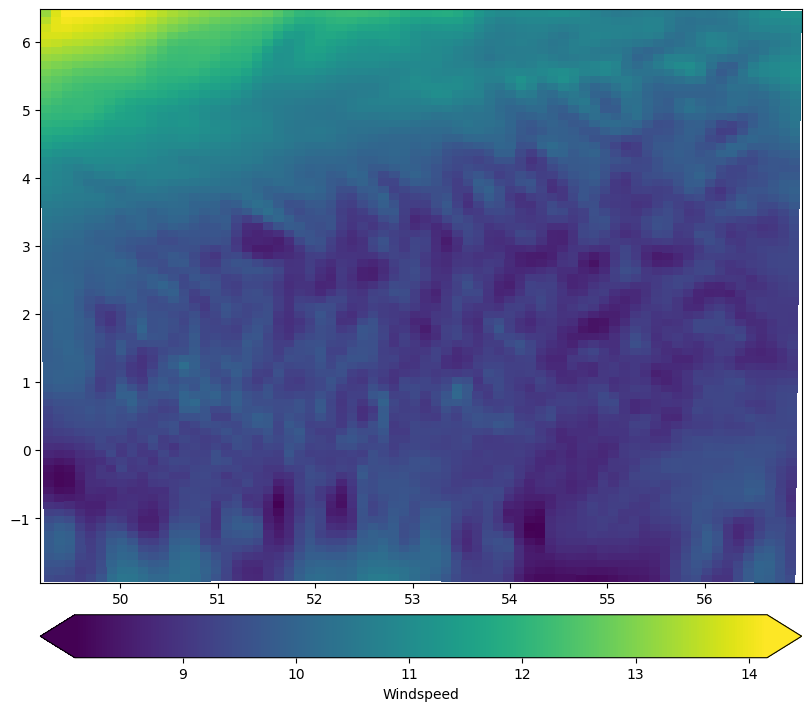

In [57]:
timestep = 20
lats = ds.coords['XLAT'][timestep]  # extract/copy the data
lons = ds.coords['XLONG'][timestep]
temp = ds.variables['windspeed'][timestep]

fig, axs = plt.subplots(figsize=(8, 7), nrows=2,ncols=1,gridspec_kw={'height_ratios': [20,1.5]},constrained_layout=True)
pcm=axs[0].pcolormesh(lons,lats,temp,cmap='viridis')
cbar=fig.colorbar(pcm,cax=axs[1], extend='both', orientation='horizontal')
cbar.set_label('Windspeed')

In [47]:
# I want to find the speed at a certain lat/lon point.

def select_point(ds, lat, lon):
    # First, find the index of the grid point nearest a specific lat/lon.   
    abslat = np.abs(ds.XLAT[0]-lat)
    abslon = np.abs(ds.XLONG[0]-lon)
    c = np.maximum(abslon, abslat)

    ([xloc], [yloc]) = np.where(c == np.min(c))

    # Now I can use that index location to get the values at the x/y diminsion
    return ds.sel(south_north=xloc, west_east=yloc)

In [58]:
# I want to find the speed at a certain lat/lon point.
lat = 52.4
lon = 4.9
point_ds = select_point(ds, lat, lon)


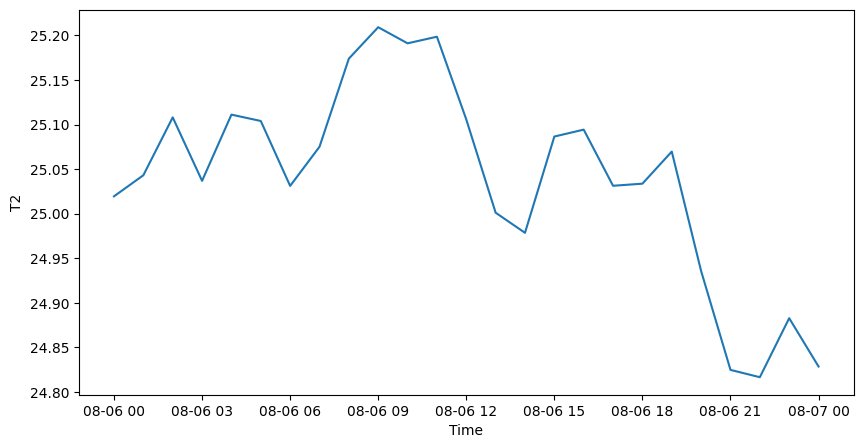

In [59]:
(point_ds["T2"] - 273.13).plot(figsize=(10,5))

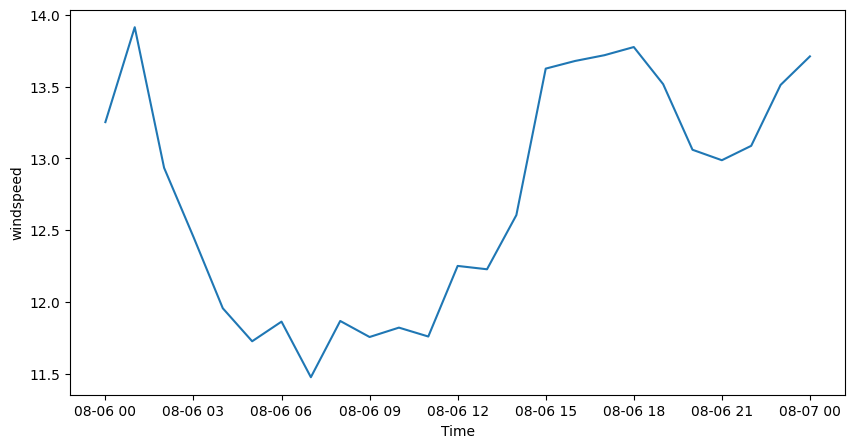

In [60]:
(point_ds["windspeed"]).plot(figsize=(10,5))

In [ ]:
ds

# Upload file to api
data format:

In [34]:
# I want to find the speed at a certain lat/lon point.
lat = 52.4
lon = 4.9
point_ds = select_point(ds, lat, lon)

In [35]:
point_ds.attrs["SIMULATION_START_DATE"]

'2022-08-06_00:00:00'

In [ ]:
point_ds.keys()

In [36]:
variables = list(point_ds.keys())
variables.sort()
variables

['ACGRDFLX',
 'ACHFX',
 'ACLHF',
 'ACSNOM',
 'ALBBCK',
 'ALBEDO',
 'AREA2D',
 'BATHYMETRY_FLAG',
 'C1F',
 'C1H',
 'C2F',
 'C2H',
 'C3F',
 'C3H',
 'C4F',
 'C4H',
 'CANWAT',
 'CF1',
 'CF2',
 'CF3',
 'CFN',
 'CFN1',
 'CLAT',
 'CLDFRA',
 'COSALPHA',
 'COSZEN',
 'DN',
 'DNW',
 'DX2D',
 'DZS',
 'E',
 'EMISS',
 'F',
 'FNM',
 'FNP',
 'GLW',
 'GOT_VAR_SSO',
 'GRAUPELNC',
 'GRDFLX',
 'HAILNC',
 'HFX',
 'HFX_FORCE',
 'HFX_FORCE_TEND',
 'HGT',
 'ISEEDARRAY_SPP_CONV',
 'ISEEDARRAY_SPP_LSM',
 'ISEEDARRAY_SPP_PBL',
 'ISEEDARR_RAND_PERTURB',
 'ISEEDARR_SKEBS',
 'ISEEDARR_SPPT',
 'ISLTYP',
 'ITIMESTEP',
 'IVGTYP',
 'LAI',
 'LAKEMASK',
 'LANDMASK',
 'LH',
 'LH_FORCE',
 'LH_FORCE_TEND',
 'LU_INDEX',
 'MAPFAC_M',
 'MAPFAC_MX',
 'MAPFAC_MY',
 'MAPFAC_U',
 'MAPFAC_UX',
 'MAPFAC_UY',
 'MAPFAC_V',
 'MAPFAC_VX',
 'MAPFAC_VY',
 'MAX_MSFTX',
 'MAX_MSFTY',
 'MF_VX_INV',
 'MU',
 'MUB',
 'NEST_POS',
 'NOAHRES',
 'OLR',
 'P',
 'P00',
 'PB',
 'PBLH',
 'PC',
 'PCB',
 'PH',
 'PHB',
 'PSFC',
 'P_HYD',
 'P_STRAT',
 'P_TO

In [ ]:
ts = pd.to_datetime(str(time.values)).strftime('%Y.%m.%d')

In [ ]:
"2022-09-01T04:00:00Z"

In [38]:
json_arr = []

forecast_timestamp = pd.to_datetime(
    point_ds.attrs["SIMULATION_START_DATE"], 
    format="%Y-%m-%d_%H:%M:%S"
).strftime('%Y-%m-%dT%H:%M:%SZ')


for i, time in enumerate(point_ds.Time):
    json_arr.append({
        "Location": "Amsterdam",
        "Timestamp": pd.to_datetime(str(time.values)).strftime('%Y-%m-%dT%H:%M:%SZ'),
        "Forecast_timestamp": forecast_timestamp,
        "windspeed": point_ds["windspeed"][i].item(),
        "wind_direction": point_ds["wind_direction"][i].item(),
        "temperature": point_ds["T2"][i].item(),
        "rain": point_ds["RAINNC"][i].item()
    })
json_arr[:2]

[{'Location': 'Amsterdam',
  'Timestamp': '2022-08-06T00:00:00Z',
  'Forecast_timestamp': '2022-08-06T00:00:00Z',
  'windspeed': 4.977859973907471,
  'wind_direction': 91.90522003173828,
  'temperature': 304.03497314453125,
  'rain': 0.0},
 {'Location': 'Amsterdam',
  'Timestamp': '2022-08-06T01:00:00Z',
  'Forecast_timestamp': '2022-08-06T00:00:00Z',
  'windspeed': 5.3921380043029785,
  'wind_direction': 36.1883430480957,
  'temperature': 304.0559997558594,
  'rain': 0.0}]

In [39]:
r = requests.post("http://localhost:8080/v1/weather", json=json_arr)
r.raise_for_status()